## Install the required libraries

In [1]:
#!pip install scikit-multilearn
#!pip install catboost

## Import the required libraries

In [6]:
# Import the required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import itertools
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

## Load the Training and Test sets.

In [2]:
#load the Training and Test sets.
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
submission = pd.read_csv('SampleSubmission.csv')

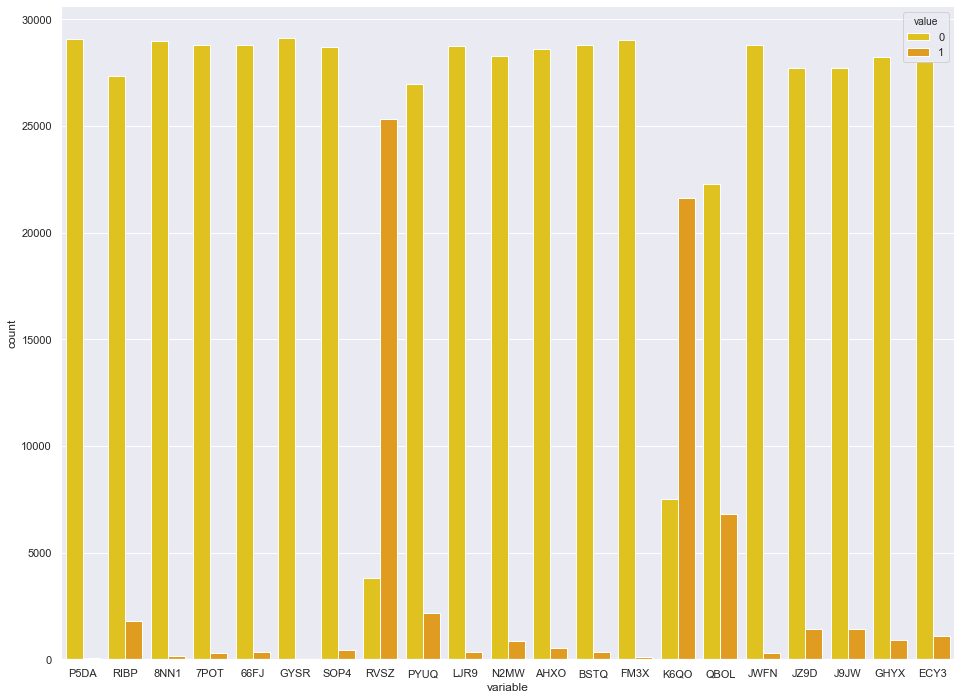

In [26]:
sns.set()
categorical_columns=train[['ID','P5DA', 'RIBP', '8NN1',
       '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
       'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']]

fig, ax1 = plt.subplots(figsize=(16,12))
data = categorical_columns.melt(id_vars='ID')
sns.countplot(x='variable', hue='value', data=data, palette=['gold','orange'])
sns.despine(fig)

In [ ]:
### The above plot shows most people have subscribe for RVSZ and KBQO

## Join Train and Test
The training and the test sets are combined to make sure both sets are normalized using the same scale.

In [4]:
joined  = pd.concat([train,test])
joined

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,P5DA,RIBP,...,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,4WKQSBB,1/2/2019,F,M,1987,1X1H,2A7I,T4MS,0,0,...,0,0,0,1,0,0,0,0,0,0
1,CP5S02H,1/6/2019,F,M,1981,UAOD,2A7I,T4MS,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2YKDILJ,1/6/2013,M,U,1991,748L,QZYX,90QI,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2S9E81J,1/8/2019,M,M,1990,1X1H,BP09,56SI,0,0,...,0,0,0,1,0,0,0,0,0,0
4,BHDYVFT,1/8/2019,M,M,1990,748L,NO3L,T4MS,0,0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0GMU5UH,1/4/2019,F,M,1986,748L,2A7I,T4MS,0,0,...,0,0,0,0,1,0,1,0,0,0
9996,I9W11CD,1/8/2019,M,M,1980,UAOD,0KID,T4MS,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,42WTEGT,1/4/2018,M,M,1993,748L,SST3,56SI,0,0,...,0,0,0,1,0,0,0,0,0,0
9998,8EKC4O9,1/5/2015,F,U,1981,49BM,2A7I,T4MS,0,0,...,0,0,0,0,0,0,0,0,0,0


### Check for null values
join_date has 3 null entries

In [5]:
joined.isnull().sum()

ID                          0
join_date                   3
sex                         0
marital_status              0
birth_year                  0
branch_code                 0
occupation_code             0
occupation_category_code    0
P5DA                        0
RIBP                        0
8NN1                        0
7POT                        0
66FJ                        0
GYSR                        0
SOP4                        0
RVSZ                        0
PYUQ                        0
LJR9                        0
N2MW                        0
AHXO                        0
BSTQ                        0
FM3X                        0
K6QO                        0
QBOL                        0
JWFN                        0
JZ9D                        0
J9JW                        0
GHYX                        0
ECY3                        0
dtype: int64

### Replace null values

In [6]:
joined["join_date"].fillna("1/1/2020", inplace = True)

### Split join_date to Day, Month and Year

In [7]:
joined[['Day','Month','Year']] = joined.join_date.str.split("/",expand=True,)

### Change data-type of Day, Year and Month to int

In [8]:
joined["Day"] = joined['Day'].astype(int)
joined["Year"] = joined.Year.astype(int)
joined["Month"] = joined.Month.astype(int)

### Calculate Age from join_date (Year) and birth_year

In [9]:
joined['Age'] = joined['Year'] - joined['birth_year']

### Use MinMax Scaler to normalize numerical columns

In [10]:
num_cols = ['Age','Year','Month','Day']
scaler = MinMaxScaler()
joined[num_cols] = scaler.fit_transform(joined[num_cols])

### Split the joined dataframe to the respective train and test sets

In [11]:
train  = joined.head(29132)
test = joined.tail(10000)

### Identify Product Features for the training and test sets.

In [12]:
features = train[['P5DA', 'RIBP', '8NN1',
       '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO','BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']]
features_test = test[['P5DA', 'RIBP', '8NN1',
       '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
       'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']]


### Duplicate Input Products

The duplicates of all products are going to be used as extra features for the purpose of training the models. The original products serve as target variables.

In [13]:
# get the list of product columns
column_list = features.columns.tolist()

# append _input at the end of each product to distinguish it from the target variable
input_column_names = [name + '_input' for name in column_list]

In [14]:
# change the names of the original products to the one that has _input appended to it 
features.columns = input_column_names
features_test.columns = input_column_names

In [15]:
## include the original products to the training and test sets.
train = train.join(features)
test = test.join(features_test)

### Getting a binary number representation of all products

In [16]:
binaries = train[['P5DA', 'RIBP', '8NN1',
       '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
       'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']].astype(str).agg(''.join, axis=1)
binaries

0        000000010000001000000
1        000000010000001000000
2        000000110000000000001
3        000000010000001000000
4        000000000000000001100
                 ...          
29127    000000010000001000000
29128    000000010000001000000
29129    000000010000001000000
29130    000000010000001000000
29131    000000010000001000000
Length: 29132, dtype: object

### Populate the data-frame by duplicating each row as many times as the number of ones in the list of products.

In [17]:

modified_binaries = []

for binary in binaries:
    i = 0
    j = 0
    current_binaries = []
    for digit in binary:
        modified_binary = ''
        
        
        if(digit=='1'):
                modified_binary = binary
                modified_string = modified_binary[:i] + '0' + modified_binary[i + 1:]
                #print(modified_string)
                current_binaries.append(modified_string)
                j+=1
        i+=1
    modified_binaries.append(current_binaries)

In [18]:
train['binaries'] = modified_binaries
train['binaries'] = train['binaries']
df = train.explode('binaries').fillna('')


### A function to separate each digit in the binary column with a comma

In [19]:
# a function that accepts a string and adds a comma b/n each character.
def separate_binaries(row):
        separated_binary = re.sub(r'([0-9])(?!$)', r'\1,', row)
        
        return separated_binary


In [20]:
df['binaries'] = df.apply(lambda row: separate_binaries(row['binaries']),axis=1)

In [21]:
df

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,P5DA,RIBP,...,BSTQ_input,FM3X_input,K6QO_input,QBOL_input,JWFN_input,JZ9D_input,J9JW_input,GHYX_input,ECY3_input,binaries
0,4WKQSBB,1/2/2019,F,M,1987,1X1H,2A7I,T4MS,0,0,...,0,0,1,0,0,0,0,0,0,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0"
0,4WKQSBB,1/2/2019,F,M,1987,1X1H,2A7I,T4MS,0,0,...,0,0,1,0,0,0,0,0,0,"0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0"
1,CP5S02H,1/6/2019,F,M,1981,UAOD,2A7I,T4MS,0,0,...,0,0,1,0,0,0,0,0,0,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0"
1,CP5S02H,1/6/2019,F,M,1981,UAOD,2A7I,T4MS,0,0,...,0,0,1,0,0,0,0,0,0,"0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0"
2,2YKDILJ,1/6/2013,M,U,1991,748L,QZYX,90QI,0,0,...,0,0,0,0,0,0,0,0,1,"0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29129,MVXG2LC,1/2/2019,M,M,1985,BOAS,6PE7,T4MS,0,0,...,0,0,1,0,0,0,0,0,0,"0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0"
29130,BUQ8DQN,1/7/2019,M,M,1989,UAOD,2A7I,T4MS,0,0,...,0,0,1,0,0,0,0,0,0,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0"
29130,BUQ8DQN,1/7/2019,M,M,1989,UAOD,2A7I,T4MS,0,0,...,0,0,1,0,0,0,0,0,0,"0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0"
29131,DEJBWYU,1/3/2020,M,M,1975,94KC,31JW,90QI,0,0,...,0,0,1,0,0,0,0,0,0,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0"


### Imitating the test data.
The test data has one of the products with a 1 entry changed to 0. That is one of the subscribed products is given as unsubscribed. The following cell changes one of the subscribed products to unsubscribed for each row of the dataframe. Remember we have duplicated each row as many times as the number of ones in the binary column of each row. So, we change a different product from 1 to 0 on each duplicate of the row.

In [22]:
df[['P5DA_input',
 'RIBP_input',
 '8NN1_input',
 '7POT_input',
 '66FJ_input',
 'GYSR_input',
 'SOP4_input',
 'RVSZ_input',
 'PYUQ_input',
 'LJR9_input',
 'N2MW_input',
 'AHXO_input',
 'BSTQ_input',
 'FM3X_input',
 'K6QO_input',
 'QBOL_input',
 'JWFN_input',
 'JZ9D_input',
 'J9JW_input',
 'GHYX_input',
 'ECY3_input',]] = df.binaries.str.split(',',expand=True,)

In [23]:
df

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,P5DA,RIBP,...,BSTQ_input,FM3X_input,K6QO_input,QBOL_input,JWFN_input,JZ9D_input,J9JW_input,GHYX_input,ECY3_input,binaries
0,4WKQSBB,1/2/2019,F,M,1987,1X1H,2A7I,T4MS,0,0,...,0,0,1,0,0,0,0,0,0,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0"
0,4WKQSBB,1/2/2019,F,M,1987,1X1H,2A7I,T4MS,0,0,...,0,0,0,0,0,0,0,0,0,"0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0"
1,CP5S02H,1/6/2019,F,M,1981,UAOD,2A7I,T4MS,0,0,...,0,0,1,0,0,0,0,0,0,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0"
1,CP5S02H,1/6/2019,F,M,1981,UAOD,2A7I,T4MS,0,0,...,0,0,0,0,0,0,0,0,0,"0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0"
2,2YKDILJ,1/6/2013,M,U,1991,748L,QZYX,90QI,0,0,...,0,0,0,0,0,0,0,0,1,"0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29129,MVXG2LC,1/2/2019,M,M,1985,BOAS,6PE7,T4MS,0,0,...,0,0,0,0,0,0,0,0,0,"0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0"
29130,BUQ8DQN,1/7/2019,M,M,1989,UAOD,2A7I,T4MS,0,0,...,0,0,1,0,0,0,0,0,0,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0"
29130,BUQ8DQN,1/7/2019,M,M,1989,UAOD,2A7I,T4MS,0,0,...,0,0,0,0,0,0,0,0,0,"0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0"
29131,DEJBWYU,1/3/2020,M,M,1975,94KC,31JW,90QI,0,0,...,0,0,1,0,0,0,0,0,0,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0"


### Drop unnecessary columns

In [24]:
# drop unnecessary columns
df = df.drop('ID', axis = 1)
df = df.drop('join_date', axis = 1)
df = df.drop('binaries', axis = 1)

In [25]:
test = test.drop('ID', axis = 1)
test = test.drop('join_date', axis = 1)

## Separate the training and test datasets to feature and target varaible

In [26]:
target = np.asarray(df[['P5DA', 'RIBP', '8NN1',
       '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
       'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']], dtype=float)

target_test = np.asarray(test[['P5DA', 'RIBP', '8NN1',
       '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
       'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']], dtype=float)
input_features = df.drop(['P5DA', 'RIBP', '8NN1',
       '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
       'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3'], axis=1, inplace=True)
input_features_test = test.drop(['P5DA', 'RIBP', '8NN1',
       '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
       'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3'], axis=1, inplace=True)

In [27]:
pd.set_option('display.max_columns', None)
test.head(2)

,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,Day,Month,Year,Age,P5DA_input,RIBP_input,8NN1_input,7POT_input,66FJ_input,GYSR_input,SOP4_input,RVSZ_input,PYUQ_input,LJR9_input,N2MW_input,AHXO_input,BSTQ_input,FM3X_input,K6QO_input,QBOL_input,JWFN_input,JZ9D_input,J9JW_input,GHYX_input,ECY3_input
0,M,M,1984,94KC,DZRV,90QI,0.0,1.000000,0.8,0.329114,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,M,M,1996,1X1H,J9SY,90QI,0.0,0.818182,0.9,0.189873,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


### One Hot Encoding of Categorical Variables

In [28]:
# apply one hot encoding on categorical variables
categorical_test = test[['sex','marital_status','branch_code','occupation_code','occupation_category_code']]
categorical_df = df[['sex','marital_status','branch_code','occupation_code','occupation_category_code']]
categorical_df = pd.get_dummies(categorical_df)
categorical_test = pd.get_dummies(categorical_test)

In [29]:
df = pd.concat([categorical_df, df], axis=1, join='inner')
df

,sex_F,sex_M,marital_status_D,marital_status_M,marital_status_P,marital_status_R,marital_status_S,marital_status_U,marital_status_W,marital_status_f,branch_code_1X1H,branch_code_30H5,branch_code_49BM,branch_code_748L,branch_code_94KC,branch_code_9F9T,branch_code_BOAS,branch_code_E5SW,branch_code_EU3L,branch_code_O4JC,branch_code_O67J,branch_code_UAOD,branch_code_X23B,branch_code_XX25,branch_code_ZFER,occupation_code_00MO,occupation_code_0B60,occupation_code_0KID,occupation_code_0OJM,occupation_code_0PO7,occupation_code_0S50,occupation_code_0SH6,occupation_code_0VYC,occupation_code_1AN5,occupation_code_1DT6,occupation_code_1H8Y,occupation_code_1MB4,occupation_code_1MSV,occupation_code_1NFK,occupation_code_1YKL,occupation_code_2346,occupation_code_2686,occupation_code_2A7I,occupation_code_2BE6,occupation_code_2G86,occupation_code_2HLT,occupation_code_2JHV,occupation_code_2MBB,occupation_code_2R78,occupation_code_2US6,occupation_code_2XZ1,occupation_code_2YAO,occupation_code_31GG,occupation_code_31JW,occupation_code_374O,occupation_code_3NHZ,occupation_code_3X46,occupation_code_3YQ1,occupation_code_44SU,occupation_code_4M0E,occupation_code_4W0D,occupation_code_59QM,occupation_code_5FPK,occupation_code_5JRZ,occupation_code_5LNN,occupation_code_5OVC,occupation_code_6E4H,occupation_code_6KYM,occupation_code_6LKA,occupation_code_6PE7,occupation_code_6SKY,occupation_code_6XXU,occupation_code_6YZA,occupation_code_734F,occupation_code_738L,occupation_code_73AC,occupation_code_74BF,occupation_code_7G9M,occupation_code_7KM4,occupation_code_7UDQ,occupation_code_7UHW,occupation_code_7UWC,occupation_code_820B,occupation_code_834U,occupation_code_8HRZ,occupation_code_8Y24,occupation_code_9B5B,occupation_code_9FA1,occupation_code_9HD1,occupation_code_9IM8,occupation_code_9IP9,occupation_code_A4ZC,occupation_code_A793,occupation_code_AIDS,occupation_code_AIIN,occupation_code_APO0,occupation_code_AQIB,occupation_code_B3QW,occupation_code_B8W8,occupation_code_BER4,occupation_code_BFD1,occupation_code_BP09,occupation_code_BPSA,occupation_code_BWBW,occupation_code_BX9E,occupation_code_C1E3,occupation_code_C8F6,occupation_code_CAAV,occupation_code_CEL6,occupation_code_CV2C,occupation_code_CYDC,occupation_code_DD8W,occupation_code_DE5D,occupation_code_DHSN,occupation_code_DPRV,occupation_code_DZRV,occupation_code_E39I,occupation_code_E5PF,occupation_code_EE5R,occupation_code_F35Z,occupation_code_F57O,occupation_code_FJBW,occupation_code_FLNZ,occupation_code_FLXH,occupation_code_FSWO,occupation_code_FSXG,occupation_code_GQ0N,occupation_code_GVZ1,occupation_code_GWEP,occupation_code_GZA8,occupation_code_H1K7,occupation_code_HAXM,occupation_code_HJF4,occupation_code_HSVE,occupation_code_HTQS,occupation_code_I2OD,occupation_code_I31I,occupation_code_IE90,occupation_code_IJ01,occupation_code_IMHI,occupation_code_INEJ,occupation_code_IQFS,occupation_code_IUT9,occupation_code_IX8T,occupation_code_IZ77,occupation_code_J9SY,occupation_code_JHU5,occupation_code_JI64,occupation_code_JN20,occupation_code_JQH3,occupation_code_JS7M,occupation_code_JSAX,occupation_code_JUIP,occupation_code_K0DL,occupation_code_K5GV,occupation_code_K5LB,occupation_code_KBWO,occupation_code_KNVN,occupation_code_KPG9,occupation_code_KUPK,occupation_code_L1P3,occupation_code_L4PL,occupation_code_LAYD,occupation_code_LGTN,occupation_code_LLLH,occupation_code_LQ0W,occupation_code_M0WG,occupation_code_MEFQ,occupation_code_MU16,occupation_code_N2ZZ,occupation_code_N7K2,occupation_code_NDL9,occupation_code_NFJH,occupation_code_NO3L,occupation_code_NQW1,occupation_code_NSJX,occupation_code_NX5Y,occupation_code_OEH6,occupation_code_OME4,occupation_code_ONY7,occupation_code_OPVX,occupation_code_OQMY,occupation_code_OYQF,occupation_code_P2K2,occupation_code_P4MD,occupation_code_PJR4,occupation_code_PKW3,occupation_code_PMAI,occupation_code_PPNK,occupation_code_PSUY,occupation_code_PWCW,occupation_code_Q0LY,occupation_code_Q231,occupation_code_Q2L0,occupation_code_Q57T,occupation_code_Q6J6,occup

In [30]:
test = categorical_test.join(test)
test

,sex_F,sex_M,marital_status_D,marital_status_F,marital_status_M,marital_status_P,marital_status_R,marital_status_S,marital_status_U,marital_status_W,branch_code_1X1H,branch_code_30H5,branch_code_49BM,branch_code_748L,branch_code_94KC,branch_code_9F9T,branch_code_BOAS,branch_code_E5SW,branch_code_EU3L,branch_code_O4JC,branch_code_O67J,branch_code_UAOD,branch_code_X23B,branch_code_XX25,branch_code_ZFER,occupation_code_00MO,occupation_code_0B60,occupation_code_0FOI,occupation_code_0KID,occupation_code_0OJM,occupation_code_0PO7,occupation_code_0S50,occupation_code_0SH6,occupation_code_0VYC,occupation_code_0ZND,occupation_code_1AN5,occupation_code_1DT6,occupation_code_1H8Y,occupation_code_1MB4,occupation_code_1MSV,occupation_code_1NFK,occupation_code_1YKL,occupation_code_2346,occupation_code_2A7I,occupation_code_2BE6,occupation_code_2G86,occupation_code_2HLT,occupation_code_2JHV,occupation_code_2MBB,occupation_code_2R78,occupation_code_2YAO,occupation_code_31GG,occupation_code_31JW,occupation_code_3NHZ,occupation_code_3X46,occupation_code_44SU,occupation_code_4M0E,occupation_code_4W0D,occupation_code_5FPK,occupation_code_5JRZ,occupation_code_5OVC,occupation_code_6E4H,occupation_code_6KYM,occupation_code_6LKA,occupation_code_6PE7,occupation_code_6YZA,occupation_code_734F,occupation_code_73AC,occupation_code_74BF,occupation_code_7G9M,occupation_code_7KM4,occupation_code_7UDQ,occupation_code_7UHW,occupation_code_7UWC,occupation_code_820B,occupation_code_834U,occupation_code_8CHJ,occupation_code_8Y24,occupation_code_93OJ,occupation_code_9F96,occupation_code_9FA1,occupation_code_9HD1,occupation_code_9IM8,occupation_code_9IP9,occupation_code_A793,occupation_code_AIDS,occupation_code_AIIN,occupation_code_APO0,occupation_code_AQIB,occupation_code_B3QW,occupation_code_B8W8,occupation_code_BIA0,occupation_code_BP09,occupation_code_BPSA,occupation_code_BWBW,occupation_code_BX9E,occupation_code_C1E3,occupation_code_C8F6,occupation_code_CEL6,occupation_code_CV2C,occupation_code_CYDC,occupation_code_DD8W,occupation_code_DE5D,occupation_code_DPRV,occupation_code_DZRV,occupation_code_E2MJ,occupation_code_E39I,occupation_code_EE5R,occupation_code_F35Z,occupation_code_F57O,occupation_code_FJBW,occupation_code_FLNZ,occupation_code_FSWO,occupation_code_FSXG,occupation_code_GQ0N,occupation_code_GVZ1,occupation_code_GWEP,occupation_code_H1K7,occupation_code_HAXM,occupation_code_HJF4,occupation_code_HSI5,occupation_code_HTQS,occupation_code_I2OD,occupation_code_I31I,occupation_code_IJ01,occupation_code_IQFS,occupation_code_IUT9,occupation_code_IZ77,occupation_code_J9SY,occupation_code_JBJP,occupation_code_JHU5,occupation_code_JI64,occupation_code_JN20,occupation_code_JS7M,occupation_code_K0DL,occupation_code_K5GV,occupation_code_K5LB,occupation_code_KNVN,occupation_code_KPG9,occupation_code_L1P3,occupation_code_L4PL,occupation_code_LAYD,occupation_code_LQ0W,occupation_code_MU16,occupation_code_N2ZZ,occupation_code_N7K2,occupation_code_NFJH,occupation_code_NO3L,occupation_code_NQW1,occupation_code_NSJX,occupation_code_NX5Y,occupation_code_OEH6,occupation_code_OME4,occupation_code_OPVX,occupation_code_OYQF,occupation_code_P2K2,occupation_code_P4MD,occupation_code_PKW3,occupation_code_PMAI,occupation_code_PWCW,occupation_code_Q231,occupation_code_Q2L0,occupation_code_Q57T,occupation_code_Q6J6,occupation_code_QJID,occupation_code_QQVA,occupation_code_QS0L,occupation_code_QX54,occupation_code_QZYX,occupation_code_R44Q,occupation_code_RE69,occupation_code_RF6M,occupation_code_RM3L,occupation_code_RSN9,occupation_code_RUFT,occupation_code_RXV3,occupation_code_RY9B,occupation_code_S96O,occupation_code_S9KU,occupation_code_SF1X,occupation_code_SS6D,occupation_code_SST3,occupation_code_SSTX,occupation_code_T6AB,occupation_code_TUN1,occupation_code_U37O,occupation_code_U9RX,occupation_code_UBBX,occupation_code_UJ5T,occupation_code_V4XX,occupation_code_VREH,occupation_code_VVTC,occupation_code_W3Y9,occupation_code_WE0G,occupation_code_WE7U,occupation_code_WIWP,occup

## Make sure the number of columns of training and test variables is the same

In [31]:
missing_cols = set( df.columns ) - set( test.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
test = test[df.columns]

In [32]:
test

,sex_F,sex_M,marital_status_D,marital_status_M,marital_status_P,marital_status_R,marital_status_S,marital_status_U,marital_status_W,marital_status_f,branch_code_1X1H,branch_code_30H5,branch_code_49BM,branch_code_748L,branch_code_94KC,branch_code_9F9T,branch_code_BOAS,branch_code_E5SW,branch_code_EU3L,branch_code_O4JC,branch_code_O67J,branch_code_UAOD,branch_code_X23B,branch_code_XX25,branch_code_ZFER,occupation_code_00MO,occupation_code_0B60,occupation_code_0KID,occupation_code_0OJM,occupation_code_0PO7,occupation_code_0S50,occupation_code_0SH6,occupation_code_0VYC,occupation_code_1AN5,occupation_code_1DT6,occupation_code_1H8Y,occupation_code_1MB4,occupation_code_1MSV,occupation_code_1NFK,occupation_code_1YKL,occupation_code_2346,occupation_code_2686,occupation_code_2A7I,occupation_code_2BE6,occupation_code_2G86,occupation_code_2HLT,occupation_code_2JHV,occupation_code_2MBB,occupation_code_2R78,occupation_code_2US6,occupation_code_2XZ1,occupation_code_2YAO,occupation_code_31GG,occupation_code_31JW,occupation_code_374O,occupation_code_3NHZ,occupation_code_3X46,occupation_code_3YQ1,occupation_code_44SU,occupation_code_4M0E,occupation_code_4W0D,occupation_code_59QM,occupation_code_5FPK,occupation_code_5JRZ,occupation_code_5LNN,occupation_code_5OVC,occupation_code_6E4H,occupation_code_6KYM,occupation_code_6LKA,occupation_code_6PE7,occupation_code_6SKY,occupation_code_6XXU,occupation_code_6YZA,occupation_code_734F,occupation_code_738L,occupation_code_73AC,occupation_code_74BF,occupation_code_7G9M,occupation_code_7KM4,occupation_code_7UDQ,occupation_code_7UHW,occupation_code_7UWC,occupation_code_820B,occupation_code_834U,occupation_code_8HRZ,occupation_code_8Y24,occupation_code_9B5B,occupation_code_9FA1,occupation_code_9HD1,occupation_code_9IM8,occupation_code_9IP9,occupation_code_A4ZC,occupation_code_A793,occupation_code_AIDS,occupation_code_AIIN,occupation_code_APO0,occupation_code_AQIB,occupation_code_B3QW,occupation_code_B8W8,occupation_code_BER4,occupation_code_BFD1,occupation_code_BP09,occupation_code_BPSA,occupation_code_BWBW,occupation_code_BX9E,occupation_code_C1E3,occupation_code_C8F6,occupation_code_CAAV,occupation_code_CEL6,occupation_code_CV2C,occupation_code_CYDC,occupation_code_DD8W,occupation_code_DE5D,occupation_code_DHSN,occupation_code_DPRV,occupation_code_DZRV,occupation_code_E39I,occupation_code_E5PF,occupation_code_EE5R,occupation_code_F35Z,occupation_code_F57O,occupation_code_FJBW,occupation_code_FLNZ,occupation_code_FLXH,occupation_code_FSWO,occupation_code_FSXG,occupation_code_GQ0N,occupation_code_GVZ1,occupation_code_GWEP,occupation_code_GZA8,occupation_code_H1K7,occupation_code_HAXM,occupation_code_HJF4,occupation_code_HSVE,occupation_code_HTQS,occupation_code_I2OD,occupation_code_I31I,occupation_code_IE90,occupation_code_IJ01,occupation_code_IMHI,occupation_code_INEJ,occupation_code_IQFS,occupation_code_IUT9,occupation_code_IX8T,occupation_code_IZ77,occupation_code_J9SY,occupation_code_JHU5,occupation_code_JI64,occupation_code_JN20,occupation_code_JQH3,occupation_code_JS7M,occupation_code_JSAX,occupation_code_JUIP,occupation_code_K0DL,occupation_code_K5GV,occupation_code_K5LB,occupation_code_KBWO,occupation_code_KNVN,occupation_code_KPG9,occupation_code_KUPK,occupation_code_L1P3,occupation_code_L4PL,occupation_code_LAYD,occupation_code_LGTN,occupation_code_LLLH,occupation_code_LQ0W,occupation_code_M0WG,occupation_code_MEFQ,occupation_code_MU16,occupation_code_N2ZZ,occupation_code_N7K2,occupation_code_NDL9,occupation_code_NFJH,occupation_code_NO3L,occupation_code_NQW1,occupation_code_NSJX,occupation_code_NX5Y,occupation_code_OEH6,occupation_code_OME4,occupation_code_ONY7,occupation_code_OPVX,occupation_code_OQMY,occupation_code_OYQF,occupation_code_P2K2,occupation_code_P4MD,occupation_code_PJR4,occupation_code_PKW3,occupation_code_PMAI,occupation_code_PPNK,occupation_code_PSUY,occupation_code_PWCW,occupation_code_Q0LY,occupation_code_Q231,occupation_code_Q2L0,occupation_code_Q57T,occupation_code_Q6J6,occup

## Drop Original Categorical columns
We are dropping the original categorical columns because they are already represented by one-hot encoding

In [33]:
df = df.drop(['sex','marital_status','branch_code','occupation_code','occupation_category_code','birth_year','Day','Month'] ,axis=1)
test = test.drop(['sex','marital_status','branch_code','occupation_code','occupation_category_code','birth_year','Day','Month'],axis=1)

In [34]:
test

,sex_F,sex_M,marital_status_D,marital_status_M,marital_status_P,marital_status_R,marital_status_S,marital_status_U,marital_status_W,marital_status_f,branch_code_1X1H,branch_code_30H5,branch_code_49BM,branch_code_748L,branch_code_94KC,branch_code_9F9T,branch_code_BOAS,branch_code_E5SW,branch_code_EU3L,branch_code_O4JC,branch_code_O67J,branch_code_UAOD,branch_code_X23B,branch_code_XX25,branch_code_ZFER,occupation_code_00MO,occupation_code_0B60,occupation_code_0KID,occupation_code_0OJM,occupation_code_0PO7,occupation_code_0S50,occupation_code_0SH6,occupation_code_0VYC,occupation_code_1AN5,occupation_code_1DT6,occupation_code_1H8Y,occupation_code_1MB4,occupation_code_1MSV,occupation_code_1NFK,occupation_code_1YKL,occupation_code_2346,occupation_code_2686,occupation_code_2A7I,occupation_code_2BE6,occupation_code_2G86,occupation_code_2HLT,occupation_code_2JHV,occupation_code_2MBB,occupation_code_2R78,occupation_code_2US6,occupation_code_2XZ1,occupation_code_2YAO,occupation_code_31GG,occupation_code_31JW,occupation_code_374O,occupation_code_3NHZ,occupation_code_3X46,occupation_code_3YQ1,occupation_code_44SU,occupation_code_4M0E,occupation_code_4W0D,occupation_code_59QM,occupation_code_5FPK,occupation_code_5JRZ,occupation_code_5LNN,occupation_code_5OVC,occupation_code_6E4H,occupation_code_6KYM,occupation_code_6LKA,occupation_code_6PE7,occupation_code_6SKY,occupation_code_6XXU,occupation_code_6YZA,occupation_code_734F,occupation_code_738L,occupation_code_73AC,occupation_code_74BF,occupation_code_7G9M,occupation_code_7KM4,occupation_code_7UDQ,occupation_code_7UHW,occupation_code_7UWC,occupation_code_820B,occupation_code_834U,occupation_code_8HRZ,occupation_code_8Y24,occupation_code_9B5B,occupation_code_9FA1,occupation_code_9HD1,occupation_code_9IM8,occupation_code_9IP9,occupation_code_A4ZC,occupation_code_A793,occupation_code_AIDS,occupation_code_AIIN,occupation_code_APO0,occupation_code_AQIB,occupation_code_B3QW,occupation_code_B8W8,occupation_code_BER4,occupation_code_BFD1,occupation_code_BP09,occupation_code_BPSA,occupation_code_BWBW,occupation_code_BX9E,occupation_code_C1E3,occupation_code_C8F6,occupation_code_CAAV,occupation_code_CEL6,occupation_code_CV2C,occupation_code_CYDC,occupation_code_DD8W,occupation_code_DE5D,occupation_code_DHSN,occupation_code_DPRV,occupation_code_DZRV,occupation_code_E39I,occupation_code_E5PF,occupation_code_EE5R,occupation_code_F35Z,occupation_code_F57O,occupation_code_FJBW,occupation_code_FLNZ,occupation_code_FLXH,occupation_code_FSWO,occupation_code_FSXG,occupation_code_GQ0N,occupation_code_GVZ1,occupation_code_GWEP,occupation_code_GZA8,occupation_code_H1K7,occupation_code_HAXM,occupation_code_HJF4,occupation_code_HSVE,occupation_code_HTQS,occupation_code_I2OD,occupation_code_I31I,occupation_code_IE90,occupation_code_IJ01,occupation_code_IMHI,occupation_code_INEJ,occupation_code_IQFS,occupation_code_IUT9,occupation_code_IX8T,occupation_code_IZ77,occupation_code_J9SY,occupation_code_JHU5,occupation_code_JI64,occupation_code_JN20,occupation_code_JQH3,occupation_code_JS7M,occupation_code_JSAX,occupation_code_JUIP,occupation_code_K0DL,occupation_code_K5GV,occupation_code_K5LB,occupation_code_KBWO,occupation_code_KNVN,occupation_code_KPG9,occupation_code_KUPK,occupation_code_L1P3,occupation_code_L4PL,occupation_code_LAYD,occupation_code_LGTN,occupation_code_LLLH,occupation_code_LQ0W,occupation_code_M0WG,occupation_code_MEFQ,occupation_code_MU16,occupation_code_N2ZZ,occupation_code_N7K2,occupation_code_NDL9,occupation_code_NFJH,occupation_code_NO3L,occupation_code_NQW1,occupation_code_NSJX,occupation_code_NX5Y,occupation_code_OEH6,occupation_code_OME4,occupation_code_ONY7,occupation_code_OPVX,occupation_code_OQMY,occupation_code_OYQF,occupation_code_P2K2,occupation_code_P4MD,occupation_code_PJR4,occupation_code_PKW3,occupation_code_PMAI,occupation_code_PPNK,occupation_code_PSUY,occupation_code_PWCW,occupation_code_Q0LY,occupation_code_Q231,occupation_code_Q2L0,occupation_code_Q57T,occupation_code_Q6J6,occup

In [35]:
df

,sex_F,sex_M,marital_status_D,marital_status_M,marital_status_P,marital_status_R,marital_status_S,marital_status_U,marital_status_W,marital_status_f,branch_code_1X1H,branch_code_30H5,branch_code_49BM,branch_code_748L,branch_code_94KC,branch_code_9F9T,branch_code_BOAS,branch_code_E5SW,branch_code_EU3L,branch_code_O4JC,branch_code_O67J,branch_code_UAOD,branch_code_X23B,branch_code_XX25,branch_code_ZFER,occupation_code_00MO,occupation_code_0B60,occupation_code_0KID,occupation_code_0OJM,occupation_code_0PO7,occupation_code_0S50,occupation_code_0SH6,occupation_code_0VYC,occupation_code_1AN5,occupation_code_1DT6,occupation_code_1H8Y,occupation_code_1MB4,occupation_code_1MSV,occupation_code_1NFK,occupation_code_1YKL,occupation_code_2346,occupation_code_2686,occupation_code_2A7I,occupation_code_2BE6,occupation_code_2G86,occupation_code_2HLT,occupation_code_2JHV,occupation_code_2MBB,occupation_code_2R78,occupation_code_2US6,occupation_code_2XZ1,occupation_code_2YAO,occupation_code_31GG,occupation_code_31JW,occupation_code_374O,occupation_code_3NHZ,occupation_code_3X46,occupation_code_3YQ1,occupation_code_44SU,occupation_code_4M0E,occupation_code_4W0D,occupation_code_59QM,occupation_code_5FPK,occupation_code_5JRZ,occupation_code_5LNN,occupation_code_5OVC,occupation_code_6E4H,occupation_code_6KYM,occupation_code_6LKA,occupation_code_6PE7,occupation_code_6SKY,occupation_code_6XXU,occupation_code_6YZA,occupation_code_734F,occupation_code_738L,occupation_code_73AC,occupation_code_74BF,occupation_code_7G9M,occupation_code_7KM4,occupation_code_7UDQ,occupation_code_7UHW,occupation_code_7UWC,occupation_code_820B,occupation_code_834U,occupation_code_8HRZ,occupation_code_8Y24,occupation_code_9B5B,occupation_code_9FA1,occupation_code_9HD1,occupation_code_9IM8,occupation_code_9IP9,occupation_code_A4ZC,occupation_code_A793,occupation_code_AIDS,occupation_code_AIIN,occupation_code_APO0,occupation_code_AQIB,occupation_code_B3QW,occupation_code_B8W8,occupation_code_BER4,occupation_code_BFD1,occupation_code_BP09,occupation_code_BPSA,occupation_code_BWBW,occupation_code_BX9E,occupation_code_C1E3,occupation_code_C8F6,occupation_code_CAAV,occupation_code_CEL6,occupation_code_CV2C,occupation_code_CYDC,occupation_code_DD8W,occupation_code_DE5D,occupation_code_DHSN,occupation_code_DPRV,occupation_code_DZRV,occupation_code_E39I,occupation_code_E5PF,occupation_code_EE5R,occupation_code_F35Z,occupation_code_F57O,occupation_code_FJBW,occupation_code_FLNZ,occupation_code_FLXH,occupation_code_FSWO,occupation_code_FSXG,occupation_code_GQ0N,occupation_code_GVZ1,occupation_code_GWEP,occupation_code_GZA8,occupation_code_H1K7,occupation_code_HAXM,occupation_code_HJF4,occupation_code_HSVE,occupation_code_HTQS,occupation_code_I2OD,occupation_code_I31I,occupation_code_IE90,occupation_code_IJ01,occupation_code_IMHI,occupation_code_INEJ,occupation_code_IQFS,occupation_code_IUT9,occupation_code_IX8T,occupation_code_IZ77,occupation_code_J9SY,occupation_code_JHU5,occupation_code_JI64,occupation_code_JN20,occupation_code_JQH3,occupation_code_JS7M,occupation_code_JSAX,occupation_code_JUIP,occupation_code_K0DL,occupation_code_K5GV,occupation_code_K5LB,occupation_code_KBWO,occupation_code_KNVN,occupation_code_KPG9,occupation_code_KUPK,occupation_code_L1P3,occupation_code_L4PL,occupation_code_LAYD,occupation_code_LGTN,occupation_code_LLLH,occupation_code_LQ0W,occupation_code_M0WG,occupation_code_MEFQ,occupation_code_MU16,occupation_code_N2ZZ,occupation_code_N7K2,occupation_code_NDL9,occupation_code_NFJH,occupation_code_NO3L,occupation_code_NQW1,occupation_code_NSJX,occupation_code_NX5Y,occupation_code_OEH6,occupation_code_OME4,occupation_code_ONY7,occupation_code_OPVX,occupation_code_OQMY,occupation_code_OYQF,occupation_code_P2K2,occupation_code_P4MD,occupation_code_PJR4,occupation_code_PKW3,occupation_code_PMAI,occupation_code_PPNK,occupation_code_PSUY,occupation_code_PWCW,occupation_code_Q0LY,occupation_code_Q231,occupation_code_Q2L0,occupation_code_Q57T,occupation_code_Q6J6,occup

### Split the trianing set to training and validation sets

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.1) 

### Change the data-type of encoded entries to float

In [37]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)
test = test.astype(float)

### Import libraries related to Model training and evaluation

In [38]:
from skmultilearn.problem_transform import ClassifierChain, LabelPowerset
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.cluster import NetworkXLabelGraphClusterer
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
from skmultilearn.ensemble import LabelSpacePartitioningClassifier
from skmultilearn.ensemble import MajorityVotingClassifier
from skmultilearn.cluster import FixedLabelSpaceClusterer
from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.problem_transform import LabelPowerset
from xgboost import XGBClassifier
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMModel,LGBMClassifier
from sklearn.metrics import log_loss, accuracy_score 




## Stacking LGBM & Catboost Classifiers

In [40]:
models = []
models.append(RandomForestClassifier(n_estimators = 1000, n_jobs=-1))
models.append(CatBoostClassifier(random_state=17, depth = 5,learning_rate=0.05))
models.append(CatBoostClassifier(random_state=90, num_trees=700, depth=5,learning_rate=0.05))
models.append(CatBoostClassifier(random_state=50, num_trees=500, depth = 5,learning_rate=0.05))
models.append(CatBoostClassifier(random_state=20, num_trees=1200, depth=5,learning_rate=0.05))
models.append(LGBMClassifier(n_estimators=150, silent=False, random_state =94,
                         max_depth=5,num_leaves=31,objective='binary'))
models.append(CatBoostClassifier(random_state=45))

In [41]:
classifiers = []

## Fit the classifiers

In [42]:
%%capture
#In the real sense we want to see how the model's doing but I did this to avoid long training lines on github

for model in models:
    classifier = ClassifierChain(
        classifier = model,
        require_dense = [False, True]
    )

    classifier.fit(X_train,y_train)
    classifiers.append(classifier)

### Use the models to predict for the test set

In [ ]:
predictions_list=[]
for i in range(len(classifiers)):
    predictions_list.append(classifiers[i].predict(test))

In [ ]:
print(predictions.toarray()[0]) 

### Get the probabilities for each product per customer

In [43]:
probabilities_list=[]
for i in range(len(classifiers)):
    probabilities_list.append(classifiers[i].predict_proba(test).todense())

#### Look at the probabilities of subscribing for the 21 products respectively for few customer.

In [ ]:
print(probabilities_list)

### Take the mean of all probabilities predicted by the models. 

In [44]:
probabilities = np.mean(probabilities_list, axis=0)

In [ ]:
probabilities[0]

### Arrange the probabilities as per the provided submission format

In [45]:
probabilities_1d = (itertools.chain.from_iterable(probabilities.tolist()))

In [46]:
submission['Label'] = list(probabilities_1d)

In [ ]:
submission

### Write the submission dataframe to csv

In [47]:
submission.to_csv('submission_finale.csv', index=False)